# Load dependencies
- Change oversample indices

In [1]:
#!python -m pip install -U SimpleITK
#!python -m pip install -U scikit-image

In [2]:
from __future__ import print_function

import SimpleITK as sitk
import sys
import os
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import ndimage
#from medpy.filter import IntensityRangeStandardization
from skimage import exposure
from scipy import ndimage
from scipy import misc

from keras.utils import to_categorical

from functions.plot_slices import plot_slices

In [3]:
from PIL import Image
#im = Image.fromarray(A)
#im.save("your_file.jpeg")

In [4]:
# Define the path + output path:
DIR = "/tf/notebooks/"
#OUTPUT_DIR = '/tf/notebooks/hezo/stroke_perfusion/callbacks/3D_CNN_ONTRAM_Zurich_mrs/'

# Import data

### Clinical and patient data

In [5]:
dat = pd.read_csv(DIR + "/hezo/stroke_perfusion/data/data_bern_25_11_2020_dwi.csv")

In [6]:
# Size of the dataframe: same as the images
dat.shape

(222, 69)

In [7]:
# define binary mRS
dat["mrs_3months_binary"] = 0
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 1

(array([32., 48., 39., 32., 32.,  5., 34.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

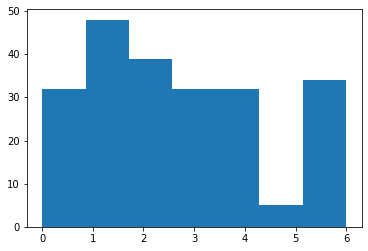

In [8]:
plt.hist(dat.mrs_3months, bins = 7)

(array([103., 119.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

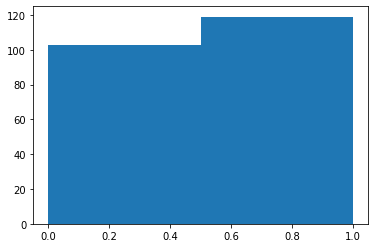

In [9]:
plt.hist(dat.mrs_3months_binary, bins = 2)

In [10]:
# simple imputation: replace all missing values with the mode of the column
for column in dat.columns:
    dat[column].fillna(dat[column].mode()[0], inplace=True)

In [11]:
dat.columns

Index(['p_id', 'columns', 'instance_no', 'path', 'rows', 'sequence',
       'modality', 'modality_no', 'folder', 'image', 'rank', 'age', 'sex',
       'independent_pre_stroke', 'nihss_bl', 'nihss_24h', 'nihss_diff_bl_24h',
       'nihss_3months', 'nihss_diff_bl_3months', 'mrs_3months',
       'death_after_3months', 'intracranial_bleeding', 'tah_pre_stroke',
       'antikoagulation_pre_stroke', 'statin_pre_stroke',
       'antihypertensiva_pre_stroke', 'sys_bloodpressure_bl',
       'dias_bloodpressure_bl', 'glucose_bl', 'hba1c', 'ldl', 'hdl',
       'triglyceride', 'crp', 'inr', 'anaesthesia', 'dense_media',
       'early_infarct_sign', 'atrial_fibrillation', 'rf_diabetes',
       'rf_hypertonia', 'rf_hypercholesterinaemie', 'rf_smoker', 'rf_chd',
       'rf_pavk', 'rf_tia_stroke', 'infarct_side', 'additional_occlusion',
       'additional_occlusion_side', 'additional_occlusion_ica_excranial',
       'additional_occlusion_ica_intracranial', 'additional_occlusion_ica_t',
       'additio

In [12]:
# tabular data for the prediction
# to make the values smaller we consider:
# a 10 unit change in age
# a 10 unit change in NIHSS
# a 20 unit change in BP
# a 120 (2h) change in time_to_imaging
X_tab = np.array([dat.age/10, dat.sex, dat.independent_pre_stroke, dat.nihss_bl/10, 
                  dat.sys_bloodpressure_bl/20, dat.time_to_imaging/120, dat.rf_hypertonia, dat.rf_smoker]).T
X_tab.shape

(222, 8)

In [13]:
Y = np.array(dat.mrs_3months_binary)
print(Y.shape)
Y = to_categorical(Y)
print(Y.shape)

(222,)
(222, 2)


### Import images

In [14]:
with h5py.File(DIR + "/hezo/stroke_perfusion/data/data_bern_25_11_2020.h5", "r") as h5:
    # Image matrix for tmax sequence
    X_dwi = h5["X_dwi"][:]
    X_adc = h5["X_adc"][:]
    X_cbv = h5["X_cbv"][:]
    X_cbf = h5["X_cbf"][:]
    X_mtt = h5["X_mtt"][:]
    X_ttp = h5["X_ttp"][:]
    X_tmax = h5["X_tmax"][:]

In [14]:
print(X_dwi.shape, X_adc.shape, X_cbv.shape, X_cbf.shape, X_mtt.shape, X_ttp.shape, X_tmax.shape)

(222, 128, 128, 64, 1) (222, 128, 128, 64, 1) (222, 128, 128, 64, 3) (222, 128, 128, 64, 3) (222, 128, 128, 64, 3) (222, 128, 128, 64, 3) (222, 128, 128, 64, 3)


In [15]:
print(X_dwi.min(), X_adc.min(), X_cbv.min(), X_cbf.min(), X_mtt.min(), X_ttp.min(), X_tmax.min())

0 0 0 0 0 0 0


In [16]:
print(X_dwi.max(), X_adc.max(), X_cbv.max(), X_cbf.max(), X_mtt.max(), X_ttp.max(), X_tmax.max())

1378 4095 255 255 255 249 255


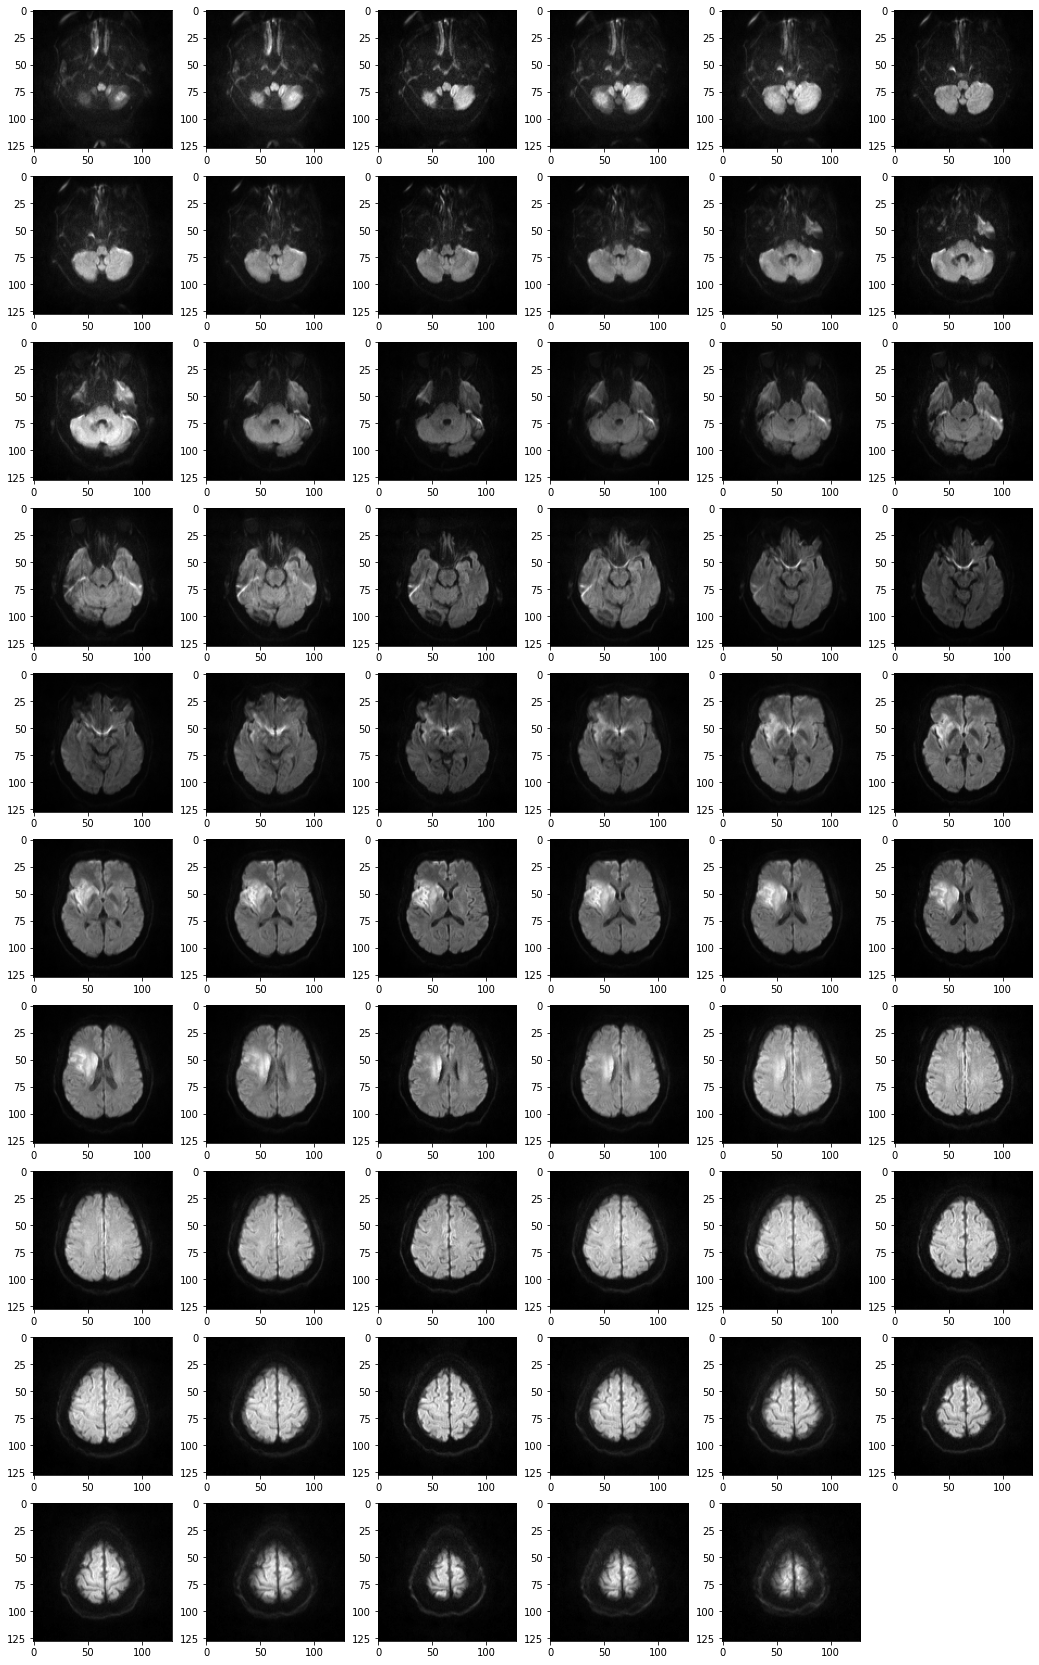

In [19]:
plot_slices(X_dwi[1], dat.loc[0,:], "axial", modality = "DWI")

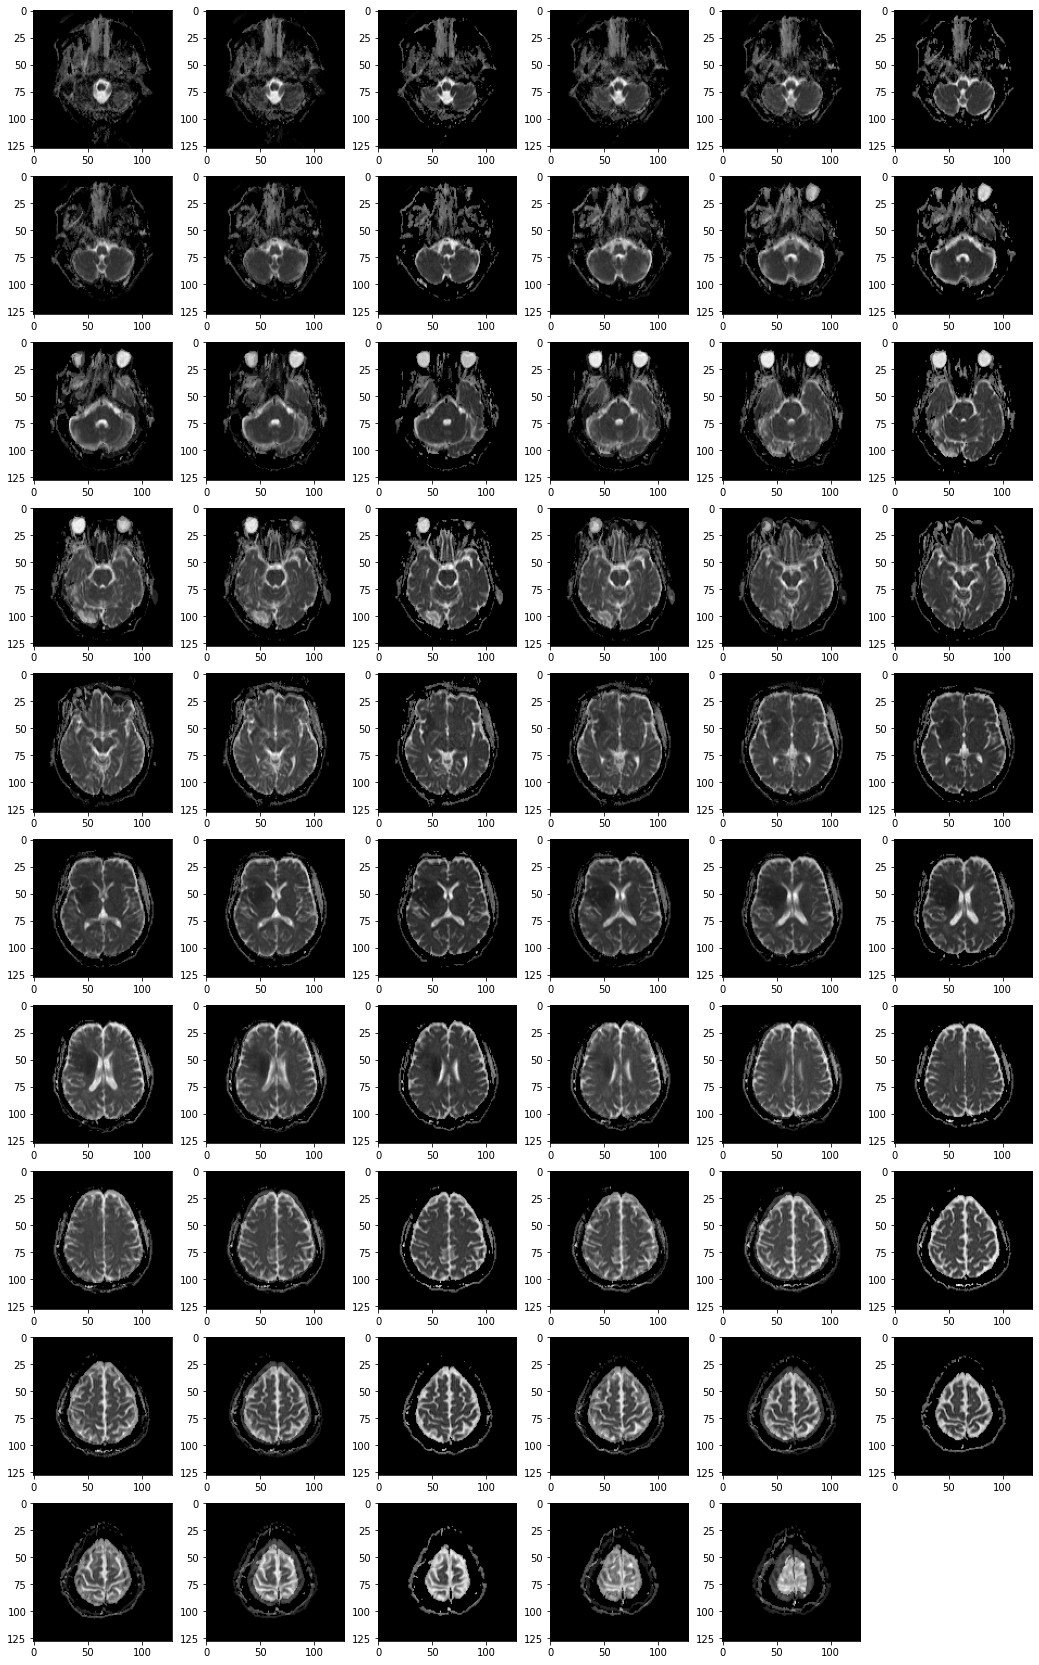

In [20]:
plot_slices(X_adc[1], dat.loc[0,:], "axial", modality = "DWI")

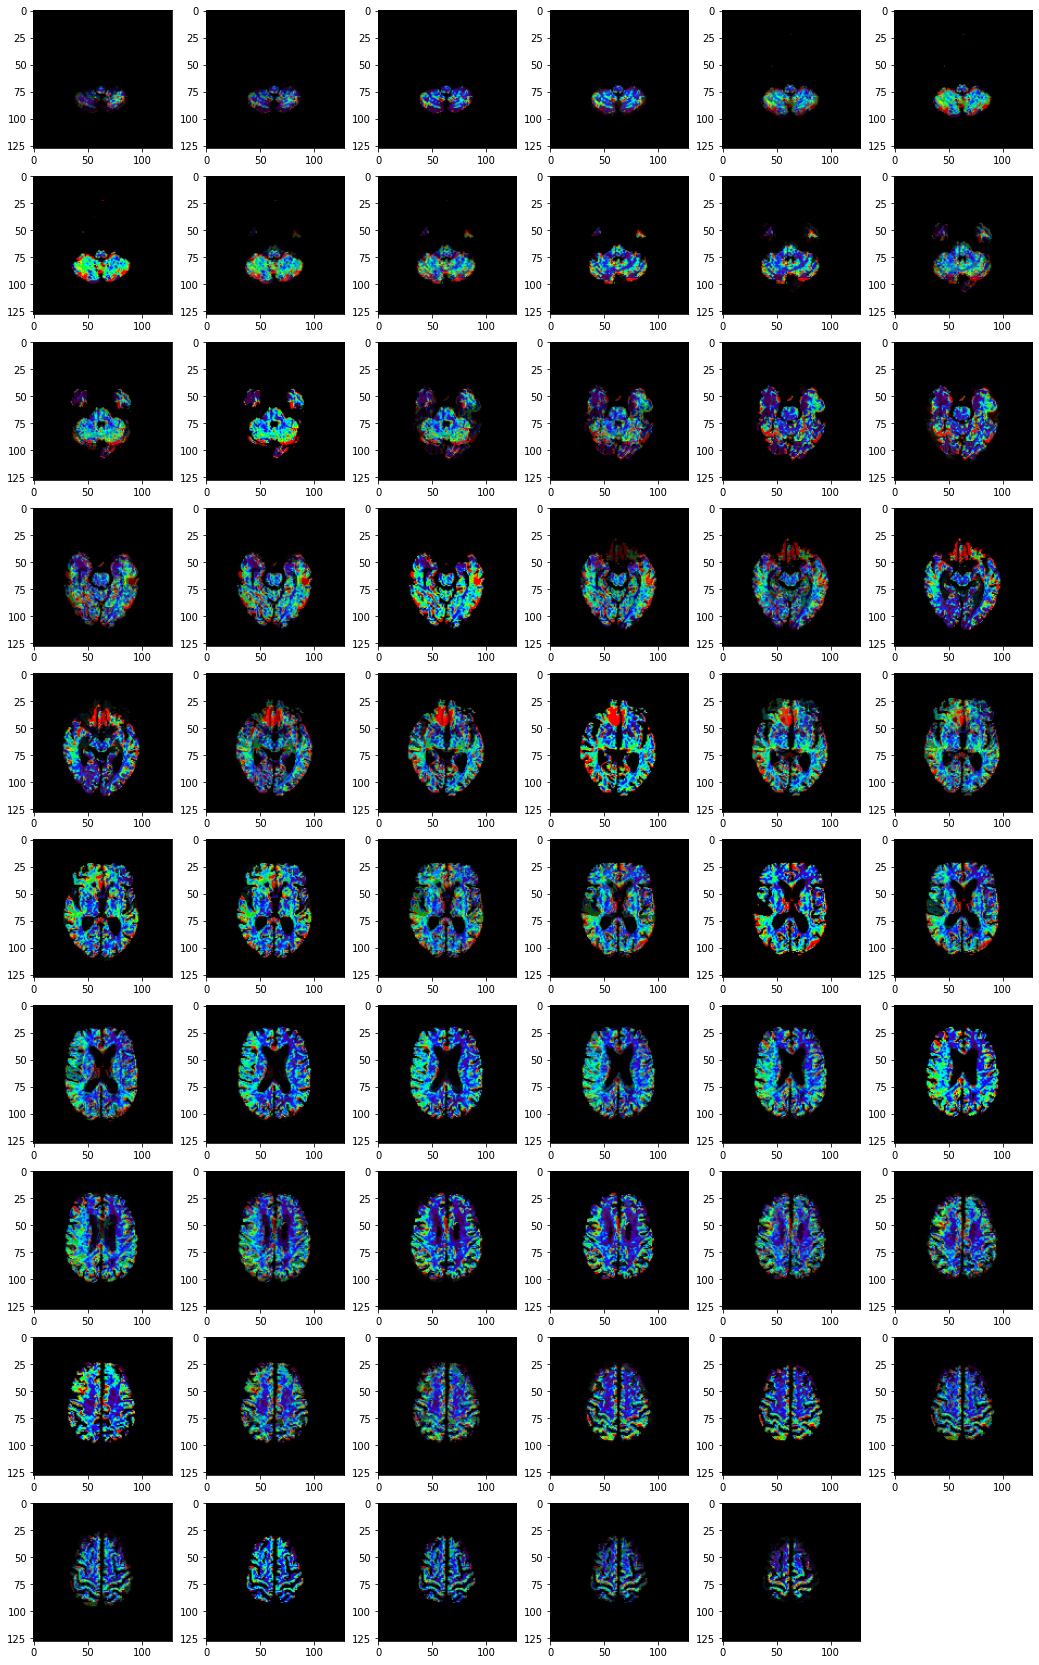

In [19]:
plot_slices(X_cbv[0], dat.loc[0,:], "axial")

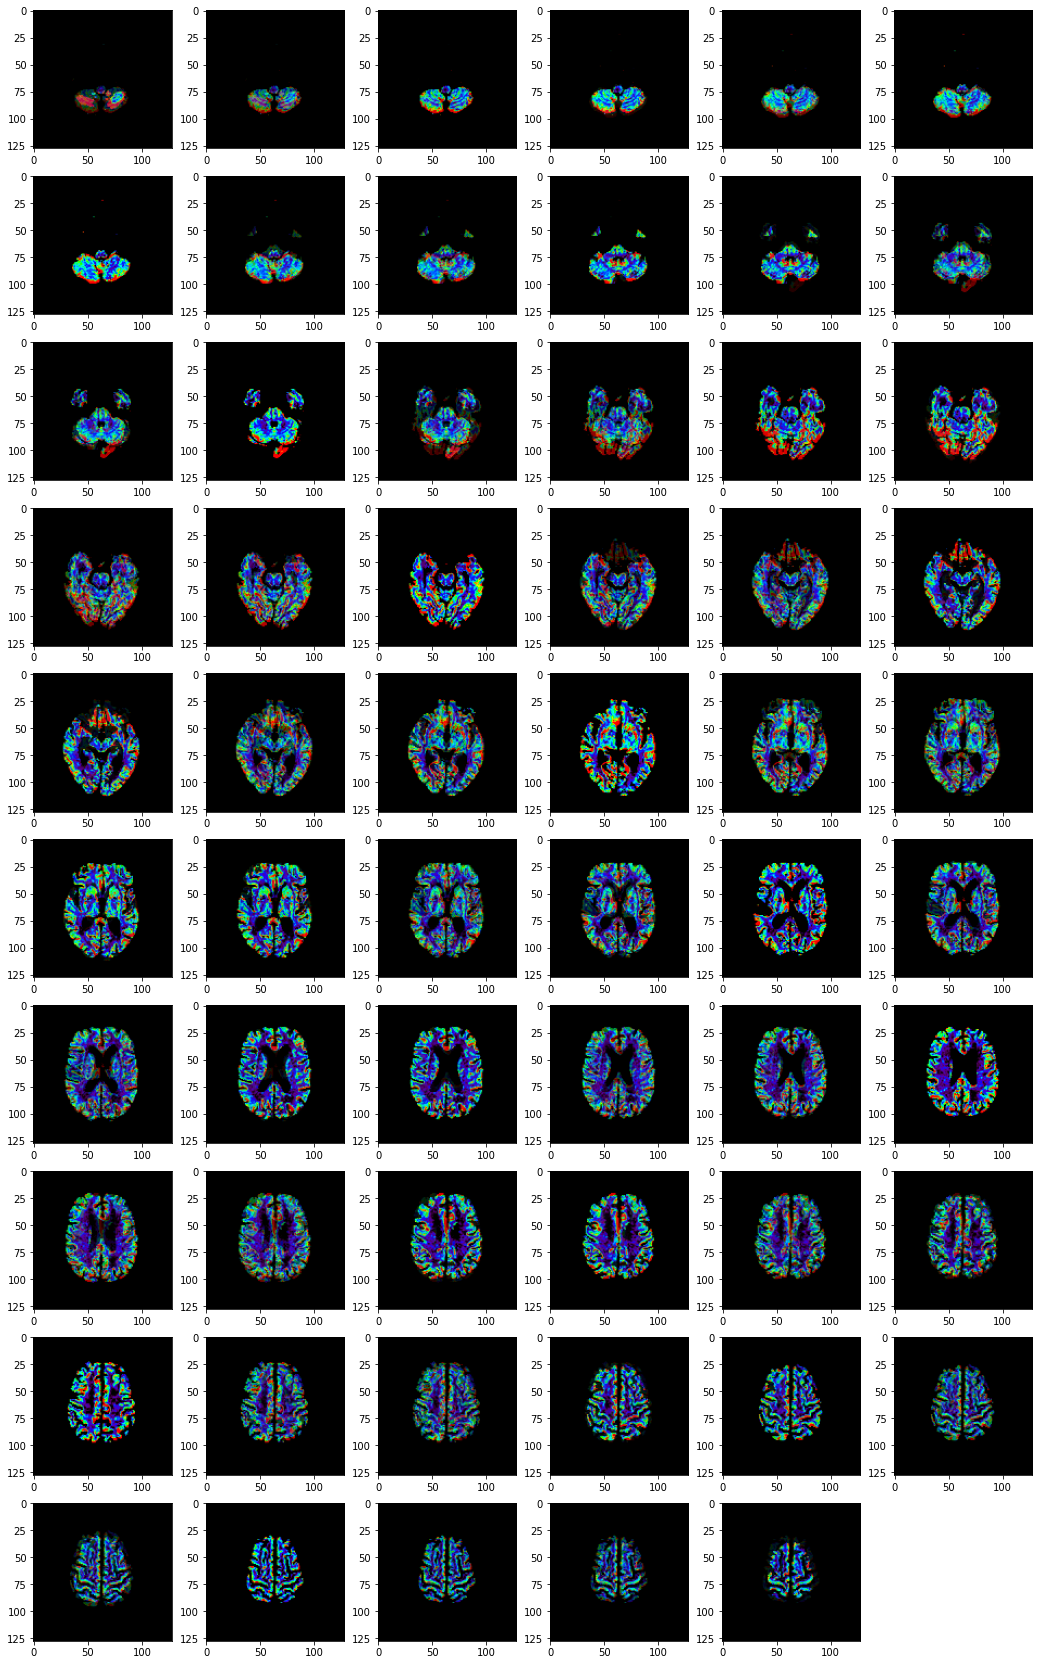

In [20]:
plot_slices(X_cbf[0], dat.loc[0,:], "axial")

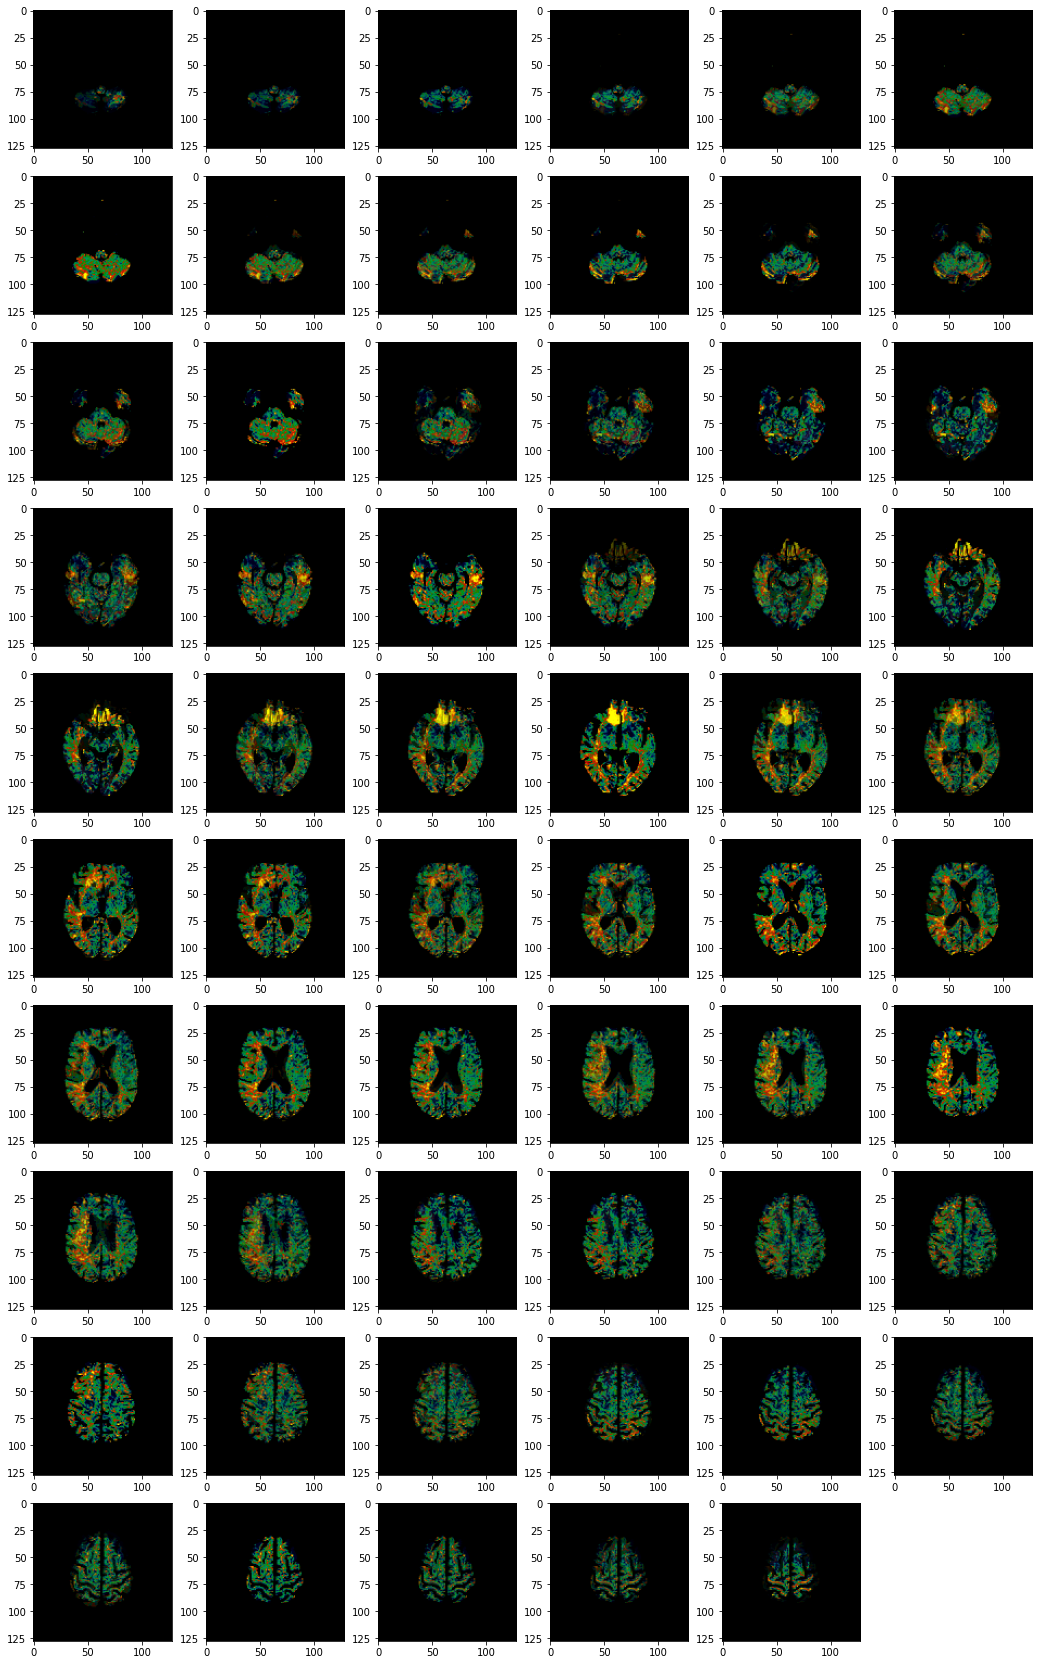

In [21]:
plot_slices(X_mtt[0], dat.loc[0,:], "axial")

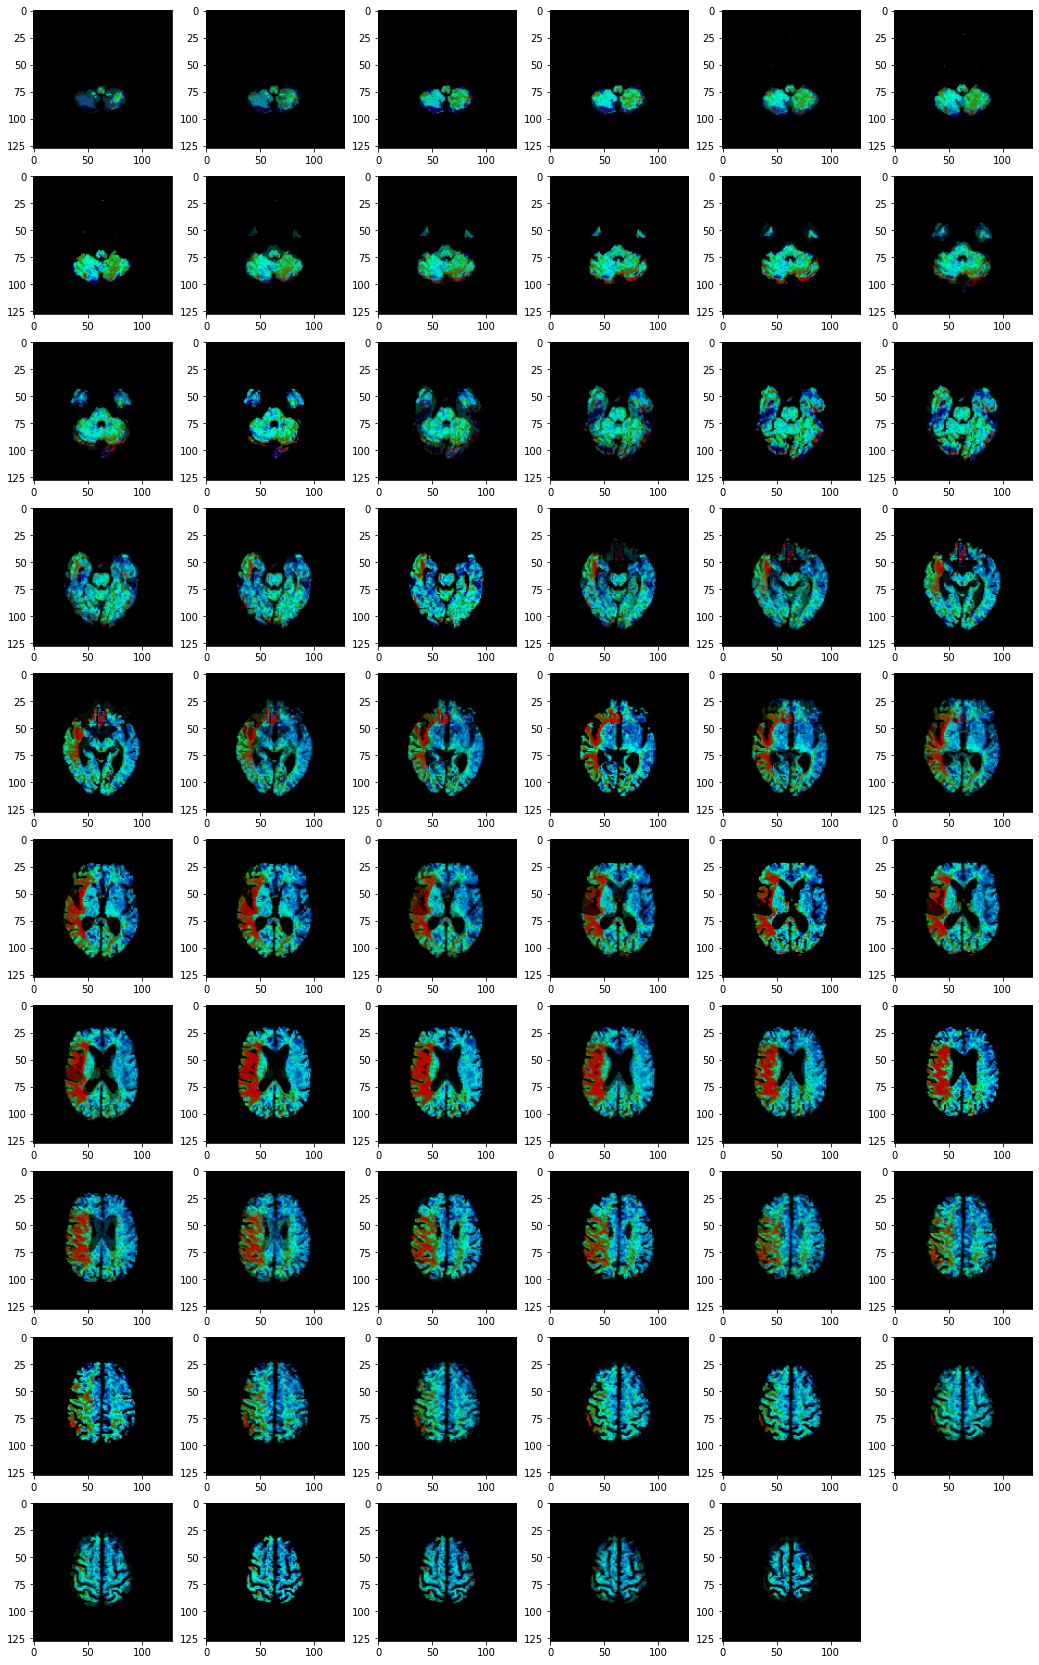

In [22]:
plot_slices(X_ttp[0], dat.loc[0,:], "axial")

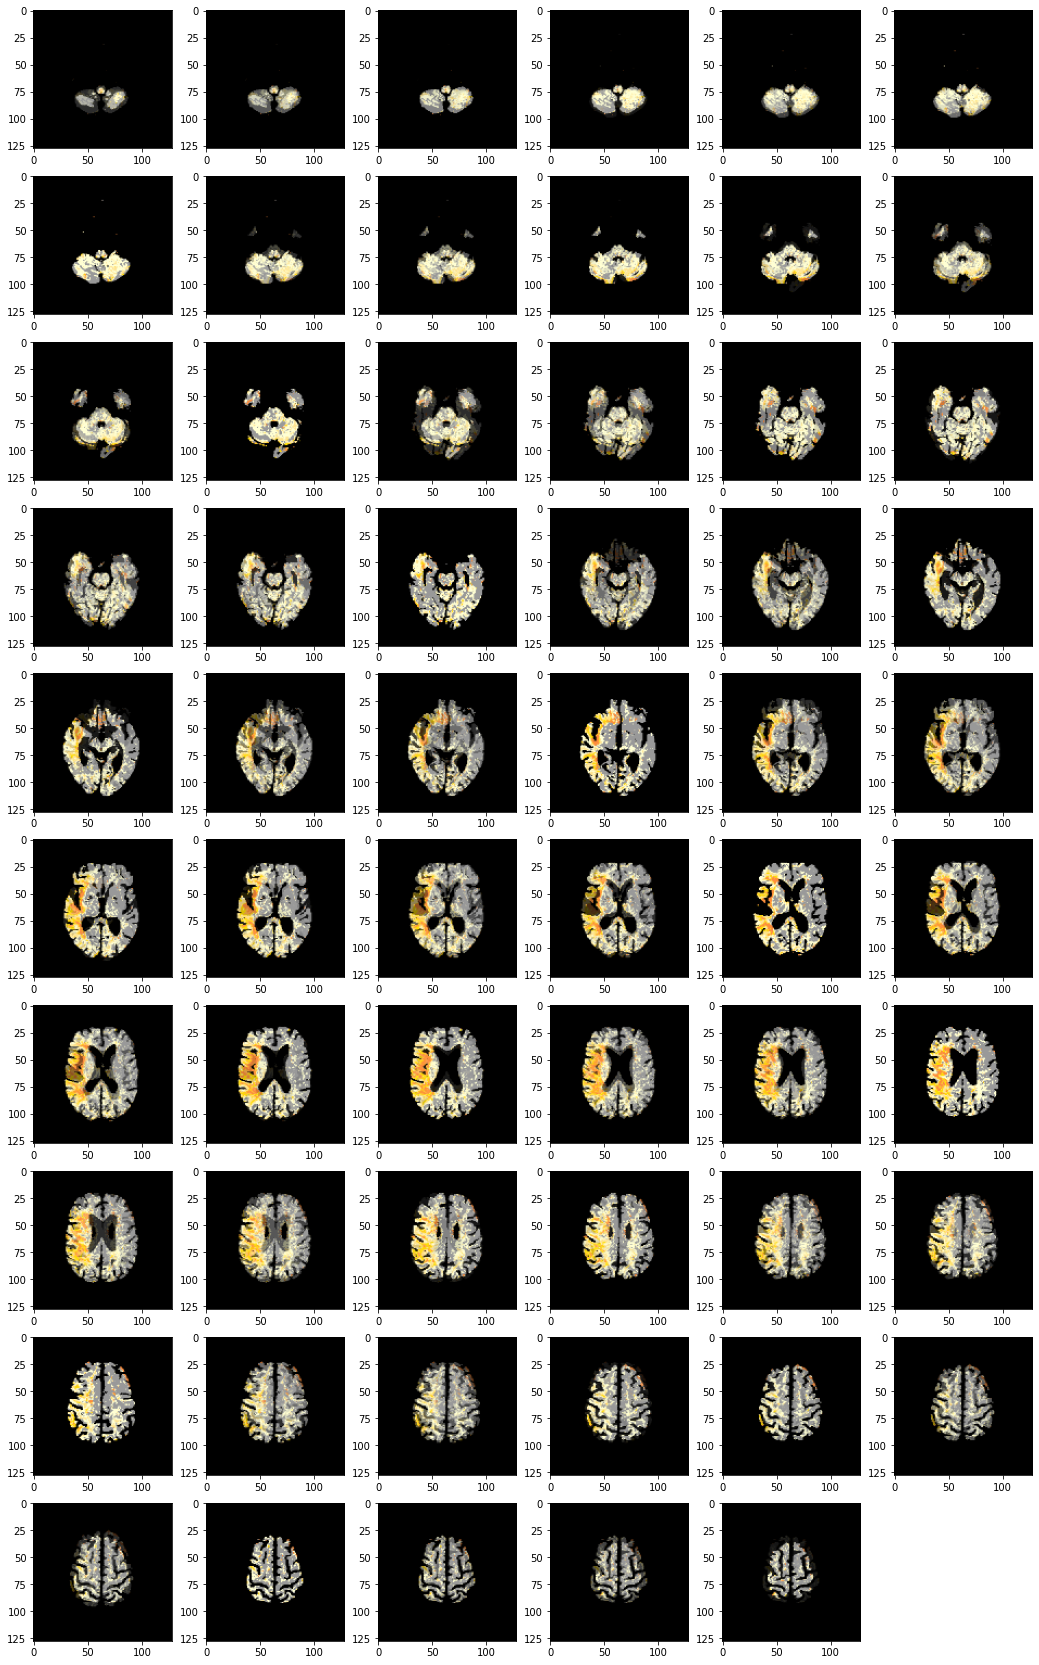

In [23]:
plot_slices(X_tmax[0], dat.loc[0,:], "axial")

In [21]:
X_dwi.shape

(222, 128, 128, 64, 1)

In [32]:
for i in [3,9,15,21,27,33,39,45,51,57,63]:
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/dwi/image-" + str(i) + ".jpeg", X_dwi[1,:,:,i,0], cmap = "gray")
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/adc/image-" + str(i) + ".jpeg", X_adc[1,:,:,i,0], cmap = "gray")
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/cbv/image-" + str(i) + ".jpeg", X_cbv[1,:,:,i,:])
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/cbf/image-" + str(i) + ".jpeg", X_cbf[1,:,:,i,:])
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/mtt/image-" + str(i) + ".jpeg", X_mtt[1,:,:,i,:])
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/ttp/image-" + str(i) + ".jpeg", X_ttp[1,:,:,i,:])
    plt.imsave("/tf/notebooks/hezo/stroke_perfusion/data/tmax/image-" + str(i) + ".jpeg", X_tmax[1,:,:,i,:])